# Modelo VAR (Vector Autoregression)

Este notebook implementa modelos VAR multivariados para predecir las ventas de dos productos simultáneamente, utilizando tres tipos de validación temporal:
- Walk-Forward Validation
- Rolling Window
- Expanding Window

**Características del modelo:**
- VAR es un modelo multivariado que predice múltiples series de tiempo simultáneamente
- Considera las relaciones entre las series (producto1 y producto2)
- Cada serie se modela como función de sus propios valores pasados y los valores pasados de las otras series
- Utiliza Optimización Bayesiana para encontrar el mejor orden del modelo
- Entrena el modelo final para producción con el mejor método de validación

**Análisis Multivariado:**
- Se incluyen análisis de correlación entre series
- Verificación de estacionariedad
- Análisis de interdependencias entre productos


In [38]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
import warnings
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')


In [39]:
# Cargar el dataset
df = pd.read_csv('data-set.csv', index_col=0)
print("Dataset cargado:")
print(f"Forma del dataset: {df.shape}")
print(f"\nPrimeras filas:")
print(df.head())
print(f"\nÚltimas filas:")
print(df.tail())
print(f"\nInformación del dataset:")
print(df.info())


Dataset cargado:
Forma del dataset: (127, 2)

Primeras filas:
    producto1   producto2
1  500.000000  200.000000
2  497.400893  210.686220
3  478.605317  222.018584
4  486.454125  233.920990
5  479.695678  238.402098

Últimas filas:
      producto1   producto2
123  164.610771  629.293034
124  150.881839  637.099467
125  151.788470  653.155282
126  137.047639  672.528345
127  141.990873  676.058092

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 127 entries, 1 to 127
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   producto1  127 non-null    float64
 1   producto2  127 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB
None


## Análisis Multivariado: Exploración de las Series

Antes de implementar el modelo VAR, realizamos análisis exploratorios para entender las relaciones entre las series.

## Verificación de Estacionariedad

El modelo VAR requiere que las series sean estacionarias. Verificamos la estacionariedad de las series originales antes de aplicar diferenciación.


ANÁLISIS DE CORRELACIÓN ENTRE SERIES

Matriz de correlación:
           producto1  producto2
producto1   1.000000  -0.730748
producto2  -0.730748   1.000000

Correlación entre producto1 y producto2: -0.7307


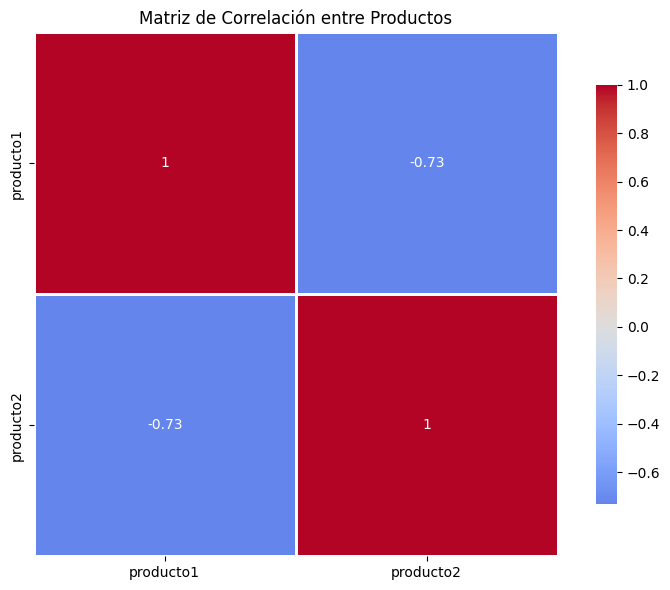


VERIFICACIÓN DE ESTACIONARIEDAD - DATOS ORIGINALES

Producto 1:
  Estadístico ADF: -0.8594
  p-value: 0.8010
  Valores críticos:
    1%: -3.4847
    5%: -2.8853
    10%: -2.5795
  ✗ Serie NO es estacionaria (p-value > 0.05)

Producto 2:
  Estadístico ADF: -2.0330
  p-value: 0.2723
  Valores críticos:
    1%: -3.4842
    5%: -2.8851
    10%: -2.5794
  ✗ Serie NO es estacionaria (p-value > 0.05)

⚠️ Advertencia: Una o ambas series no son estacionarias.
VAR requiere series estacionarias. Se aplicará diferenciación.


In [40]:
# Función para verificar estacionariedad
def check_stationarity(series, name):
    """
    Realiza prueba de Dickey-Fuller aumentada para verificar estacionariedad.
    
    Parameters:
    -----------
    series : pandas.Series
        Serie temporal a verificar
    name : str
        Nombre de la serie para el reporte
    
    Returns:
    --------
    bool
        True si la serie es estacionaria, False en caso contrario
    """
    result = adfuller(series.dropna())
    print(f"\n{name}:")
    print(f"  Estadístico ADF: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  Valores críticos:")
    for key, value in result[4].items():
        print(f"    {key}: {value:.4f}")
    
    if result[1] <= 0.05:
        print(f"  ✓ Serie es estacionaria (p-value <= 0.05)")
        return True
    else:
        print(f"  ✗ Serie NO es estacionaria (p-value > 0.05)")
        return False

# Análisis de correlación entre las series
print("=" * 60)
print("ANÁLISIS DE CORRELACIÓN ENTRE SERIES")
print("=" * 60)
correlation = df.corr()
print("\nMatriz de correlación:")
print(correlation)
print(f"\nCorrelación entre producto1 y producto2: {correlation.loc['producto1', 'producto2']:.4f}")

# Visualización de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación entre Productos')
plt.tight_layout()
plt.show()

# Verificación de estacionariedad de los datos originales
print("\n" + "=" * 60)
print("VERIFICACIÓN DE ESTACIONARIEDAD - DATOS ORIGINALES")
print("=" * 60)
stationary_p1 = check_stationarity(df['producto1'], 'Producto 1')
stationary_p2 = check_stationarity(df['producto2'], 'Producto 2')

if not stationary_p1 or not stationary_p2:
    print("\n⚠️ Advertencia: Una o ambas series no son estacionarias.")
    print("VAR requiere series estacionarias. Se aplicará diferenciación.")
else:
    print("\n✓ Ambas series son estacionarias. No se requiere diferenciación.")


## Aplicación de Diferenciación

Como las series no son estacionarias, aplicamos diferenciación para hacerlas estacionarias antes de aplicar el modelo VAR. La diferenciación ayuda a eliminar tendencias y hacer las series más estables.


In [41]:
# Aplicar diferenciación para hacer las series estacionarias
print("=" * 60)
print("APLICACIÓN DE DIFERENCIACIÓN")
print("=" * 60)

# Guardar los datos originales
df_original = df.copy()

# Aplicar primera diferenciación
df_diff = df.diff().dropna()

print(f"\nDatos originales: {len(df_original)} observaciones")
print(f"Datos diferenciados (primera diferenciación): {len(df_diff)} observaciones")
print(f"\nPrimeras filas de datos diferenciados:")
print(df_diff.head())

# Verificar estacionariedad después de la primera diferenciación
print("\n" + "=" * 60)
print("VERIFICACIÓN DE ESTACIONARIEDAD DESPUÉS DE PRIMERA DIFERENCIACIÓN")
print("=" * 60)

stationary_p1_diff = check_stationarity(df_diff['producto1'], 'Producto 1 (diferenciado)')
stationary_p2_diff = check_stationarity(df_diff['producto2'], 'Producto 2 (diferenciado)')

# Inicializar variables
USE_DIFFERENCED_DATA = True
DIFF_ORDER = 1

if stationary_p1_diff and stationary_p2_diff:
    print("\n✓ Ambas series diferenciadas son estacionarias. Proceder con VAR.")
else:
    print("\n⚠️ Advertencia: Una o ambas series diferenciadas aún no son estacionarias.")
    print("Aplicando segunda diferenciación...")
    
    # Aplicar segunda diferenciación
    df_diff = df_diff.diff().dropna()
    DIFF_ORDER = 2
    print(f"\nDatos con doble diferenciación: {len(df_diff)} observaciones")
    
    # Verificar estacionariedad después de la segunda diferenciación
    print("\n" + "=" * 60)
    print("VERIFICACIÓN DE ESTACIONARIEDAD DESPUÉS DE SEGUNDA DIFERENCIACIÓN")
    print("=" * 60)
    
    stationary_p1_diff2 = check_stationarity(df_diff['producto1'], 'Producto 1 (doble diferenciado)')
    stationary_p2_diff2 = check_stationarity(df_diff['producto2'], 'Producto 2 (doble diferenciado)')
    
    if stationary_p1_diff2 and stationary_p2_diff2:
        print("\n✓ Ambas series con doble diferenciación son estacionarias.")
    else:
        print("\n⚠️ Continuando con datos diferenciados aunque no sean completamente estacionarios.")

# Resumen final
print("\n" + "=" * 60)
print("RESUMEN DE DIFERENCIACIÓN")
print("=" * 60)
print(f"Orden de diferenciación aplicado: {DIFF_ORDER}")
print(f"Usaremos datos diferenciados: {USE_DIFFERENCED_DATA}")
print(f"Datos originales: {len(df_original)} observaciones")
print(f"Datos diferenciados: {len(df_diff)} observaciones")
print(f"\n✓ Los datos diferenciados se usarán para entrenar el modelo VAR.")


APLICACIÓN DE DIFERENCIACIÓN

Datos originales: 127 observaciones
Datos diferenciados (primera diferenciación): 126 observaciones

Primeras filas de datos diferenciados:
   producto1  producto2
2  -2.599107  10.686220
3 -18.795576  11.332365
4   7.848808  11.902406
5  -6.758448   4.481108
6  -5.473185   9.221717

VERIFICACIÓN DE ESTACIONARIEDAD DESPUÉS DE PRIMERA DIFERENCIACIÓN

Producto 1 (diferenciado):
  Estadístico ADF: -2.7659
  p-value: 0.0633
  Valores críticos:
    1%: -3.4847
    5%: -2.8853
    10%: -2.5795
  ✗ Serie NO es estacionaria (p-value > 0.05)

Producto 2 (diferenciado):
  Estadístico ADF: -3.3572
  p-value: 0.0125
  Valores críticos:
    1%: -3.4842
    5%: -2.8851
    10%: -2.5794
  ✓ Serie es estacionaria (p-value <= 0.05)

⚠️ Advertencia: Una o ambas series diferenciadas aún no son estacionarias.
Aplicando segunda diferenciación...

Datos con doble diferenciación: 125 observaciones

VERIFICACIÓN DE ESTACIONARIEDAD DESPUÉS DE SEGUNDA DIFERENCIACIÓN

Producto 1 (do

## Función VAR

Implementación del modelo VAR que permite especificar el orden del modelo:
- **order**: Orden del modelo VAR (número de lags a incluir)
- El modelo predice ambas series simultáneamente considerando sus interdependencias


In [43]:
def var_forecast(data, order, forecast_horizon=1, use_differenced=True, diff_order=1, original_last_values=None):
    """
    Calcula el modelo VAR y realiza predicciones para ambas series.
    Si se usan datos diferenciados, revierte la diferenciación en las predicciones.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame con las series temporales (debe tener columnas producto1 y producto2)
    order : int
        Orden del modelo VAR (número de lags)
    forecast_horizon : int
        Número de períodos a predecir (por defecto 1)
    use_differenced : bool
        Si True, los datos están diferenciados y se debe revertir la diferenciación
    diff_order : int
        Orden de diferenciación aplicado (1 o 2)
    original_last_values : array-like, optional
        Últimos valores originales antes de la diferenciación (necesario para revertir)
    
    Returns:
    --------
    numpy.ndarray
        Array de predicciones con forma (forecast_horizon, n_series)
        Primera columna: producto1, Segunda columna: producto2
        Si use_differenced=True, las predicciones están en la escala original
    """
    if len(data) < order + 1:
        # Si no hay suficientes datos, devolver el último valor observado
        if use_differenced and original_last_values is not None:
            # Si usamos datos diferenciados, devolver los valores originales
            return np.tile(original_last_values, (forecast_horizon, 1))
        else:
            last_values = data.iloc[-1].values
            return np.tile(last_values, (forecast_horizon, 1))
    
    try:
        # Asegurar que los datos están en el formato correcto
        data_clean = data.copy()
        
        # Crear y ajustar el modelo VAR
        model = VAR(data_clean)
        fit = model.fit(maxlags=order, ic='aic')
        
        # Realizar predicción en datos diferenciados
        forecast_diff = fit.forecast(data_clean.values[-order:], steps=forecast_horizon)
        
        # Si usamos datos diferenciados, revertir la diferenciación
        if use_differenced and original_last_values is not None:
            forecast_original = np.zeros_like(forecast_diff)
            
            if diff_order == 1:
                # Revertir primera diferenciación: y_t = y_{t-1} + diff_t
                for i in range(forecast_horizon):
                    if i == 0:
                        forecast_original[i] = original_last_values + forecast_diff[i]
                    else:
                        forecast_original[i] = forecast_original[i-1] + forecast_diff[i]
            elif diff_order == 2:
                # Revertir doble diferenciación
                # Necesitamos los dos últimos valores originales
                # Para simplificar, usamos el último valor dos veces
                last_val = original_last_values
                prev_val = original_last_values  # Aproximación
                
                for i in range(forecast_horizon):
                    if i == 0:
                        # Primera reversión: diff1_t = y_t - y_{t-1}
                        diff1 = last_val - prev_val
                        # Segunda reversión: y_t = y_{t-1} + diff1_t + diff2_t
                        forecast_original[i] = last_val + diff1 + forecast_diff[i]
                    else:
                        # Para pasos siguientes
                        diff1_prev = forecast_original[i-1] - last_val if i == 1 else forecast_original[i-1] - forecast_original[i-2]
                        forecast_original[i] = forecast_original[i-1] + diff1_prev + forecast_diff[i]
            
            return forecast_original
        else:
            # Si no usamos diferenciación, devolver predicción directa
            return forecast_diff
        
    except Exception as e:
        # En caso de error, usar el último valor como predicción
        if use_differenced and original_last_values is not None:
            return np.tile(original_last_values, (forecast_horizon, 1))
        else:
            last_values = data.iloc[-1].values
            return np.tile(last_values, (forecast_horizon, 1))


## Función 1: Walk-Forward Validation
    
En Walk-Forward Validation, se entrena el modelo con datos hasta un punto específico y se valida con el siguiente punto. Luego se avanza un paso y se repite el proceso.


In [44]:
def walk_forward_validation(dataset, order, train_size_min=24, use_differenced=True, diff_order=1, original_dataset=None):
    """
    Realiza validación Walk-Forward para el modelo VAR multivariado.
    
    Parameters:
    -----------
    dataset : pandas.DataFrame
        Dataset con las columnas de productos (producto1 y producto2) - datos diferenciados
    order : int
        Orden del modelo VAR
    train_size_min : int
        Tamaño mínimo de entrenamiento antes de comenzar la validación (por defecto 24)
    use_differenced : bool
        Si True, los datos están diferenciados
    diff_order : int
        Orden de diferenciación aplicado
    original_dataset : pandas.DataFrame, optional
        Dataset original antes de diferenciación (necesario para obtener valores reales)
    
    Returns:
    --------
    dict
        Diccionario con métricas para cada producto:
        - 'producto1': lista de diccionarios con métricas por iteración
        - 'producto2': lista de diccionarios con métricas por iteración
        Cada diccionario contiene: iteracion, ventana, rmse, mae
    """
    results = {}
    n = len(dataset)
    
    # Inicializar listas de métricas para cada producto
    metrics_list_p1 = []
    metrics_list_p2 = []
    
    print(f"\n=== Walk-Forward Validation para Modelo VAR (orden={order}) ===")
    
    # Comenzar validación desde train_size_min hasta n-1
    for i in range(train_size_min, n):
        # Datos de entrenamiento: desde el inicio hasta i
        train_data = dataset.iloc[:i]
        # Datos de validación: i (en escala original si usamos diferenciación)
        if use_differenced and original_dataset is not None:
            # El índice i en datos diferenciados corresponde a i+diff_order en datos originales
            actual_idx = i + diff_order
            if actual_idx < len(original_dataset):
                actual = original_dataset.iloc[actual_idx].values
            else:
                actual = original_dataset.iloc[-1].values
        else:
            actual = dataset.iloc[i].values  # [producto1, producto2]
        
        # Obtener últimos valores originales para revertir diferenciación
        if use_differenced and original_dataset is not None:
            # El último valor original antes de la diferenciación
            last_original_idx = i + diff_order - 1
            if last_original_idx >= 0 and last_original_idx < len(original_dataset):
                original_last_values = original_dataset.iloc[last_original_idx].values
            else:
                original_last_values = original_dataset.iloc[0].values
        else:
            original_last_values = None
        
        # Realizar predicción
        try:
            forecast = var_forecast(
                train_data, 
                order=order, 
                forecast_horizon=1,
                use_differenced=use_differenced,
                diff_order=diff_order,
                original_last_values=original_last_values
            )
            prediction = forecast[0]  # Primera (y única) predicción: [producto1, producto2]
        except Exception as e:
            if use_differenced and original_dataset is not None:
                prediction = original_last_values if original_last_values is not None else original_dataset.iloc[0].values
            else:
                prediction = train_data.iloc[-1].values  # Fallback al último valor
        
        # Calcular métricas para cada producto
        # Producto 1
        rmse_p1 = np.sqrt(mean_squared_error([actual[0]], [prediction[0]]))
        mae_p1 = mean_absolute_error([actual[0]], [prediction[0]])
        
        metrics_list_p1.append({
            'iteracion': i - train_size_min + 1,
            'ventana': i,
            'rmse': rmse_p1,
            'mae': mae_p1
        })
        
        # Producto 2
        rmse_p2 = np.sqrt(mean_squared_error([actual[1]], [prediction[1]]))
        mae_p2 = mean_absolute_error([actual[1]], [prediction[1]])
        
        metrics_list_p2.append({
            'iteracion': i - train_size_min + 1,
            'ventana': i,
            'rmse': rmse_p2,
            'mae': mae_p2
        })
        
        if (i - train_size_min + 1) % 20 == 0:
            print(f"  Iteración {i - train_size_min + 1}/{n - train_size_min}: "
                  f"RMSE_p1={rmse_p1:.4f}, RMSE_p2={rmse_p2:.4f}")
    
    results['producto1'] = metrics_list_p1
    results['producto2'] = metrics_list_p2
    
    print(f"  Total de iteraciones: {len(metrics_list_p1)}")
    
    return results


## Función 2: Rolling Window Validation

En Rolling Window Validation, se utiliza una ventana fija de tamaño constante que se desliza a lo largo de la serie temporal.


In [45]:
def rolling_window_validation(dataset, order, train_window_size=24, use_differenced=True, diff_order=1, original_dataset=None):
    """
    Realiza validación Rolling Window para el modelo VAR multivariado.
    
    Parameters:
    -----------
    dataset : pandas.DataFrame
        Dataset con las columnas de productos (producto1 y producto2) - datos diferenciados
    order : int
        Orden del modelo VAR
    train_window_size : int
        Tamaño fijo de la ventana de entrenamiento (por defecto 24)
    use_differenced : bool
        Si True, los datos están diferenciados
    diff_order : int
        Orden de diferenciación aplicado
    original_dataset : pandas.DataFrame, optional
        Dataset original antes de diferenciación (necesario para obtener valores reales)
    
    Returns:
    --------
    dict
        Diccionario con métricas para cada producto:
        - 'producto1': lista de diccionarios con métricas por iteración
        - 'producto2': lista de diccionarios con métricas por iteración
        Cada diccionario contiene: iteracion, ventana, rmse, mae
    """
    results = {}
    n = len(dataset)
    
    # Inicializar listas de métricas para cada producto
    metrics_list_p1 = []
    metrics_list_p2 = []
    
    print(f"\n=== Rolling Window Validation para Modelo VAR (orden={order}) ===")
    
    # Comenzar desde train_window_size hasta n-1
    for i in range(train_window_size, n):
        # Datos de entrenamiento: ventana fija de tamaño train_window_size
        train_data = dataset.iloc[i - train_window_size:i]
        # Datos de validación: i (en escala original si usamos diferenciación)
        if use_differenced and original_dataset is not None:
            actual_idx = i + diff_order
            if actual_idx < len(original_dataset):
                actual = original_dataset.iloc[actual_idx].values
            else:
                actual = original_dataset.iloc[-1].values
        else:
            actual = dataset.iloc[i].values  # [producto1, producto2]
        
        # Obtener últimos valores originales para revertir diferenciación
        if use_differenced and original_dataset is not None:
            last_original_idx = i + diff_order - 1
            if last_original_idx >= 0 and last_original_idx < len(original_dataset):
                original_last_values = original_dataset.iloc[last_original_idx].values
            else:
                original_last_values = original_dataset.iloc[0].values
        else:
            original_last_values = None
        
        # Realizar predicción
        try:
            forecast = var_forecast(
                train_data, 
                order=order, 
                forecast_horizon=1,
                use_differenced=use_differenced,
                diff_order=diff_order,
                original_last_values=original_last_values
            )
            prediction = forecast[0]  # Primera (y única) predicción: [producto1, producto2]
        except Exception as e:
            if use_differenced and original_dataset is not None:
                prediction = original_last_values if original_last_values is not None else original_dataset.iloc[0].values
            else:
                prediction = train_data.iloc[-1].values  # Fallback al último valor
        
        # Calcular métricas para cada producto
        # Producto 1
        rmse_p1 = np.sqrt(mean_squared_error([actual[0]], [prediction[0]]))
        mae_p1 = mean_absolute_error([actual[0]], [prediction[0]])
        
        metrics_list_p1.append({
            'iteracion': i - train_window_size + 1,
            'ventana': f"{i - train_window_size}-{i}",
            'rmse': rmse_p1,
            'mae': mae_p1
        })
        
        # Producto 2
        rmse_p2 = np.sqrt(mean_squared_error([actual[1]], [prediction[1]]))
        mae_p2 = mean_absolute_error([actual[1]], [prediction[1]])
        
        metrics_list_p2.append({
            'iteracion': i - train_window_size + 1,
            'ventana': f"{i - train_window_size}-{i}",
            'rmse': rmse_p2,
            'mae': mae_p2
        })
        
        if (i - train_window_size + 1) % 20 == 0:
            print(f"  Iteración {i - train_window_size + 1}/{n - train_window_size}: "
                  f"RMSE_p1={rmse_p1:.4f}, RMSE_p2={rmse_p2:.4f}")
    
    results['producto1'] = metrics_list_p1
    results['producto2'] = metrics_list_p2
    
    print(f"  Total de iteraciones: {len(metrics_list_p1)}")
    
    return results


## Función 3: Expanding Window Validation

En Expanding Window Validation, la ventana de entrenamiento crece con cada iteración, comenzando desde un tamaño mínimo y expandiéndose hasta incluir todos los datos disponibles hasta ese punto.


In [46]:
def expanding_window_validation(dataset, order, train_size_min=24, use_differenced=True, diff_order=1, original_dataset=None):
    """
    Realiza validación Expanding Window para el modelo VAR multivariado.
    
    Parameters:
    -----------
    dataset : pandas.DataFrame
        Dataset con las columnas de productos (producto1 y producto2) - datos diferenciados
    order : int
        Orden del modelo VAR
    train_size_min : int
        Tamaño mínimo inicial de la ventana de entrenamiento (por defecto 24)
    use_differenced : bool
        Si True, los datos están diferenciados
    diff_order : int
        Orden de diferenciación aplicado
    original_dataset : pandas.DataFrame, optional
        Dataset original antes de diferenciación (necesario para obtener valores reales)
    
    Returns:
    --------
    dict
        Diccionario con métricas para cada producto:
        - 'producto1': lista de diccionarios con métricas por iteración
        - 'producto2': lista de diccionarios con métricas por iteración
        Cada diccionario contiene: iteracion, ventana, rmse, mae
    """
    results = {}
    n = len(dataset)
    
    # Inicializar listas de métricas para cada producto
    metrics_list_p1 = []
    metrics_list_p2 = []
    
    print(f"\n=== Expanding Window Validation para Modelo VAR (orden={order}) ===")
    
    # Comenzar validación desde train_size_min hasta n-1
    for i in range(train_size_min, n):
        # Datos de entrenamiento: desde el inicio hasta i (ventana que se expande)
        train_data = dataset.iloc[:i]
        # Datos de validación: i (en escala original si usamos diferenciación)
        if use_differenced and original_dataset is not None:
            actual_idx = i + diff_order
            if actual_idx < len(original_dataset):
                actual = original_dataset.iloc[actual_idx].values
            else:
                actual = original_dataset.iloc[-1].values
        else:
            actual = dataset.iloc[i].values  # [producto1, producto2]
        
        # Obtener últimos valores originales para revertir diferenciación
        if use_differenced and original_dataset is not None:
            last_original_idx = i + diff_order - 1
            if last_original_idx >= 0 and last_original_idx < len(original_dataset):
                original_last_values = original_dataset.iloc[last_original_idx].values
            else:
                original_last_values = original_dataset.iloc[0].values
        else:
            original_last_values = None
        
        # Realizar predicción
        try:
            forecast = var_forecast(
                train_data, 
                order=order, 
                forecast_horizon=1,
                use_differenced=use_differenced,
                diff_order=diff_order,
                original_last_values=original_last_values
            )
            prediction = forecast[0]  # Primera (y única) predicción: [producto1, producto2]
        except Exception as e:
            if use_differenced and original_dataset is not None:
                prediction = original_last_values if original_last_values is not None else original_dataset.iloc[0].values
            else:
                prediction = train_data.iloc[-1].values  # Fallback al último valor
        
        # Calcular métricas para cada producto
        # Producto 1
        rmse_p1 = np.sqrt(mean_squared_error([actual[0]], [prediction[0]]))
        mae_p1 = mean_absolute_error([actual[0]], [prediction[0]])
        
        metrics_list_p1.append({
            'iteracion': i - train_size_min + 1,
            'ventana': i,  # Tamaño de la ventana que se expande
            'rmse': rmse_p1,
            'mae': mae_p1
        })
        
        # Producto 2
        rmse_p2 = np.sqrt(mean_squared_error([actual[1]], [prediction[1]]))
        mae_p2 = mean_absolute_error([actual[1]], [prediction[1]])
        
        metrics_list_p2.append({
            'iteracion': i - train_size_min + 1,
            'ventana': i,  # Tamaño de la ventana que se expande
            'rmse': rmse_p2,
            'mae': mae_p2
        })
        
        if (i - train_size_min + 1) % 20 == 0:
            print(f"  Iteración {i - train_size_min + 1}/{n - train_size_min}: "
                  f"RMSE_p1={rmse_p1:.4f}, RMSE_p2={rmse_p2:.4f}")
    
    results['producto1'] = metrics_list_p1
    results['producto2'] = metrics_list_p2
    
    print(f"  Total de iteraciones: {len(metrics_list_p1)}")
    
    return results


## Ejecución de las Validaciones

Después de definir las funciones que permitirán ejecutar el modelo teniendo en cuenta los tres tipos de validación, ahora ejecutamos las tres validaciones usando los **datos diferenciados** (si se aplicó diferenciación) y calculamos las métricas promedio.

**Configuración inicial del modelo VAR:**
- Orden inicial: 2 (se optimizará después)
- Datos: Se usarán los datos diferenciados si están disponibles


In [47]:
# Parámetros de validación
TRAIN_SIZE_MIN = 24  # Tamaño mínimo de entrenamiento
TRAIN_WINDOW_SIZE = 24  # Tamaño fijo para Rolling Window

# Orden inicial del modelo VAR (se optimizará después)
INITIAL_ORDER = 2

print("=" * 60)
print("CONFIGURACIÓN INICIAL DEL MODELO VAR")
print("=" * 60)
print(f"Tamaño mínimo de entrenamiento: {TRAIN_SIZE_MIN}")
print(f"Tamaño de ventana fija (Rolling): {TRAIN_WINDOW_SIZE}")
print(f"Orden inicial del modelo VAR: {INITIAL_ORDER}")

# Verificar si se aplicó diferenciación y usar datos diferenciados
if 'USE_DIFFERENCED_DATA' in globals() and USE_DIFFERENCED_DATA:
    print(f"\n✓ Se usarán datos diferenciados (orden: {DIFF_ORDER})")
    print(f"  Datos originales: {len(df_original)} observaciones")
    print(f"  Datos diferenciados: {len(df_diff)} observaciones")
    data_for_validation = df_diff
else:
    print(f"\n✓ Se usarán datos originales (sin diferenciación)")
    data_for_validation = df
    USE_DIFFERENCED_DATA = False
    DIFF_ORDER = 0
    df_original = df.copy()


CONFIGURACIÓN INICIAL DEL MODELO VAR
Tamaño mínimo de entrenamiento: 24
Tamaño de ventana fija (Rolling): 24
Orden inicial del modelo VAR: 2

✓ Se usarán datos diferenciados (orden: 2)
  Datos originales: 127 observaciones
  Datos diferenciados: 125 observaciones


In [48]:
# Ejecutar Walk-Forward Validation usando datos diferenciados
print("\n" + "=" * 60)
print("WALK-FORWARD VALIDATION")
print("=" * 60)

results_wf = walk_forward_validation(
    data_for_validation,
    order=INITIAL_ORDER,
    train_size_min=TRAIN_SIZE_MIN,
    use_differenced=USE_DIFFERENCED_DATA,
    diff_order=DIFF_ORDER,
    original_dataset=df_original if USE_DIFFERENCED_DATA else None
)



WALK-FORWARD VALIDATION

=== Walk-Forward Validation para Modelo VAR (orden=2) ===
  Iteración 20/101: RMSE_p1=12.1990, RMSE_p2=30.4574
  Iteración 40/101: RMSE_p1=18.1531, RMSE_p2=5.0658
  Iteración 60/101: RMSE_p1=8.0479, RMSE_p2=14.3486
  Iteración 80/101: RMSE_p1=14.0772, RMSE_p2=7.0468
  Iteración 100/101: RMSE_p1=1.2306, RMSE_p2=25.4724
  Total de iteraciones: 101


In [49]:
# Ejecutar Rolling Window Validation usando datos diferenciados
print("\n" + "=" * 60)
print("ROLLING WINDOW VALIDATION")
print("=" * 60)

results_rw = rolling_window_validation(
    data_for_validation,
    order=INITIAL_ORDER,
    train_window_size=TRAIN_WINDOW_SIZE,
    use_differenced=USE_DIFFERENCED_DATA,
    diff_order=DIFF_ORDER,
    original_dataset=df_original if USE_DIFFERENCED_DATA else None
)



ROLLING WINDOW VALIDATION

=== Rolling Window Validation para Modelo VAR (orden=2) ===
  Iteración 20/101: RMSE_p1=10.4176, RMSE_p2=29.8716
  Iteración 40/101: RMSE_p1=17.9838, RMSE_p2=12.4813
  Iteración 60/101: RMSE_p1=4.6937, RMSE_p2=14.0650
  Iteración 80/101: RMSE_p1=11.8929, RMSE_p2=7.8938
  Iteración 100/101: RMSE_p1=2.1791, RMSE_p2=22.0828
  Total de iteraciones: 101


In [50]:
# Ejecutar Expanding Window Validation usando datos diferenciados
print("\n" + "=" * 60)
print("EXPANDING WINDOW VALIDATION")
print("=" * 60)

results_ew = expanding_window_validation(
    data_for_validation,
    order=INITIAL_ORDER,
    train_size_min=TRAIN_SIZE_MIN,
    use_differenced=USE_DIFFERENCED_DATA,
    diff_order=DIFF_ORDER,
    original_dataset=df_original if USE_DIFFERENCED_DATA else None
)



EXPANDING WINDOW VALIDATION

=== Expanding Window Validation para Modelo VAR (orden=2) ===
  Iteración 20/101: RMSE_p1=12.1990, RMSE_p2=30.4574
  Iteración 40/101: RMSE_p1=18.1531, RMSE_p2=5.0658
  Iteración 60/101: RMSE_p1=8.0479, RMSE_p2=14.3486
  Iteración 80/101: RMSE_p1=14.0772, RMSE_p2=7.0468
  Iteración 100/101: RMSE_p1=1.2306, RMSE_p2=25.4724
  Total de iteraciones: 101


In [51]:
def calcular_metricas_promedio(results, nombre_validacion):
    """
    Calcula las métricas promedio para cada producto.
    
    Parameters:
    -----------
    results : dict
        Resultados de la validación
    nombre_validacion : str
        Nombre del tipo de validación
    
    Returns:
    --------
    dict
        Diccionario con métricas promedio por producto
    """
    metricas_promedio = {}
    
    print(f"\n{'='*60}")
    print(f"MÉTRICAS PROMEDIO - {nombre_validacion.upper()}")
    print(f"{'='*60}")
    
    for producto in results.keys():
        metrics_list = results[producto]
        
        # Calcular promedios
        rmse_promedio = np.mean([m['rmse'] for m in metrics_list])
        mae_promedio = np.mean([m['mae'] for m in metrics_list])
        
        metricas_promedio[producto] = {
            'rmse_promedio': rmse_promedio,
            'mae_promedio': mae_promedio,
            'num_iteraciones': len(metrics_list)
        }
        
        print(f"\n{producto}:")
        print(f"  RMSE Promedio: {rmse_promedio:.4f}")
        print(f"  MAE Promedio: {mae_promedio:.4f}")
        print(f"  Número de iteraciones: {len(metrics_list)}")
    
    return metricas_promedio

# Calcular métricas promedio para cada tipo de validación
metricas_wf = calcular_metricas_promedio(results_wf, "Walk-Forward")
metricas_rw = calcular_metricas_promedio(results_rw, "Rolling Window")
metricas_ew = calcular_metricas_promedio(results_ew, "Expanding Window")



MÉTRICAS PROMEDIO - WALK-FORWARD

producto1:
  RMSE Promedio: 8.9271
  MAE Promedio: 8.9271
  Número de iteraciones: 101

producto2:
  RMSE Promedio: 15.1489
  MAE Promedio: 15.1489
  Número de iteraciones: 101

MÉTRICAS PROMEDIO - ROLLING WINDOW

producto1:
  RMSE Promedio: 9.2028
  MAE Promedio: 9.2028
  Número de iteraciones: 101

producto2:
  RMSE Promedio: 15.5392
  MAE Promedio: 15.5392
  Número de iteraciones: 101

MÉTRICAS PROMEDIO - EXPANDING WINDOW

producto1:
  RMSE Promedio: 8.9271
  MAE Promedio: 8.9271
  Número de iteraciones: 101

producto2:
  RMSE Promedio: 15.1489
  MAE Promedio: 15.1489
  Número de iteraciones: 101


## Comparación de Resultados y Selección del Mejor Método de Validación

Comparamos los RMSE promedio de cada tipo de validación para seleccionar el mejor método. Para modelos multivariados, consideramos el RMSE promedio de ambas series.


In [52]:
# Crear DataFrame comparativo
comparacion = []

for producto in df.columns:
    comparacion.append({
        'Producto': producto,
        'Validacion': 'Walk-Forward',
        'RMSE_Promedio': metricas_wf[producto]['rmse_promedio'],
        'MAE_Promedio': metricas_wf[producto]['mae_promedio']
    })
    comparacion.append({
        'Producto': producto,
        'Validacion': 'Rolling Window',
        'RMSE_Promedio': metricas_rw[producto]['rmse_promedio'],
        'MAE_Promedio': metricas_rw[producto]['mae_promedio']
    })
    comparacion.append({
        'Producto': producto,
        'Validacion': 'Expanding Window',
        'RMSE_Promedio': metricas_ew[producto]['rmse_promedio'],
        'MAE_Promedio': metricas_ew[producto]['mae_promedio']
    })

df_comparacion = pd.DataFrame(comparacion)
print("\n" + "=" * 80)
print("COMPARACIÓN DE MÉTODOS DE VALIDACIÓN")
print("=" * 80)
print(df_comparacion.to_string(index=False))

# Calcular RMSE promedio agregado (promedio de ambos productos) para cada método
print("\n" + "=" * 80)
print("RMSE PROMEDIO AGREGADO (promedio de ambos productos)")
print("=" * 80)
rmse_agregado = {}
for validacion in ['Walk-Forward', 'Rolling Window', 'Expanding Window']:
    rmse_p1 = df_comparacion[(df_comparacion['Validacion'] == validacion) & 
                             (df_comparacion['Producto'] == 'producto1')]['RMSE_Promedio'].values[0]
    rmse_p2 = df_comparacion[(df_comparacion['Validacion'] == validacion) & 
                             (df_comparacion['Producto'] == 'producto2')]['RMSE_Promedio'].values[0]
    rmse_agregado[validacion] = (rmse_p1 + rmse_p2) / 2
    print(f"{validacion}: {rmse_agregado[validacion]:.4f}")

# Identificar el mejor método basado en RMSE agregado
mejor_validacion_agregada = min(rmse_agregado, key=rmse_agregado.get)
print(f"\nMejor método de validación (basado en RMSE agregado): {mejor_validacion_agregada}")

# Identificar el mejor método para cada producto
print("\n" + "=" * 80)
print("MEJOR MÉTODO DE VALIDACIÓN POR PRODUCTO (basado en RMSE Promedio)")
print("=" * 80)
mejor_validacion = {}
for producto in df.columns:
    producto_df = df_comparacion[df_comparacion['Producto'] == producto]
    mejor = producto_df.loc[producto_df['RMSE_Promedio'].idxmin()]
    mejor_validacion[producto] = mejor['Validacion']
    print(f"\n{producto}:")
    print(f"  Mejor método: {mejor['Validacion']}")
    print(f"  RMSE Promedio: {mejor['RMSE_Promedio']:.4f}")

# Usar el mejor método agregado para optimización
mejor_metodo_global = mejor_validacion_agregada
print(f"\n{'='*80}")
print(f"MÉTODO SELECCIONADO PARA OPTIMIZACIÓN: {mejor_metodo_global}")
print(f"{'='*80}")



COMPARACIÓN DE MÉTODOS DE VALIDACIÓN
 Producto       Validacion  RMSE_Promedio  MAE_Promedio
producto1     Walk-Forward       8.927137      8.927137
producto1   Rolling Window       9.202775      9.202775
producto1 Expanding Window       8.927137      8.927137
producto2     Walk-Forward      15.148872     15.148872
producto2   Rolling Window      15.539231     15.539231
producto2 Expanding Window      15.148872     15.148872

RMSE PROMEDIO AGREGADO (promedio de ambos productos)
Walk-Forward: 12.0380
Rolling Window: 12.3710
Expanding Window: 12.0380

Mejor método de validación (basado en RMSE agregado): Walk-Forward

MEJOR MÉTODO DE VALIDACIÓN POR PRODUCTO (basado en RMSE Promedio)

producto1:
  Mejor método: Walk-Forward
  RMSE Promedio: 8.9271

producto2:
  Mejor método: Walk-Forward
  RMSE Promedio: 15.1489

MÉTODO SELECCIONADO PARA OPTIMIZACIÓN: Walk-Forward


## Optimización Bayesiana para Encontrar el Mejor Orden del Modelo VAR

Utilizamos Optimización Bayesiana (Optuna) para optimizar el orden del modelo VAR. El orden determina cuántos lags de ambas series se incluyen en el modelo.


In [53]:
def objective_walk_forward(trial, data, train_size_min=24, use_differenced=True, diff_order=1, original_dataset=None):
    """
    Función objetivo para optimización bayesiana usando Walk-Forward Validation.
    """
    order = trial.suggest_int('order', 1, 10)
    
    n = len(data)
    errors = []
    
    for i in range(train_size_min, n):
        train_data = data.iloc[:i]
        
        # Obtener valor real en escala original
        if use_differenced and original_dataset is not None:
            actual_idx = i + diff_order
            if actual_idx < len(original_dataset):
                actual = original_dataset.iloc[actual_idx].values
            else:
                actual = original_dataset.iloc[-1].values
            last_original_idx = i + diff_order - 1
            if last_original_idx >= 0 and last_original_idx < len(original_dataset):
                original_last_values = original_dataset.iloc[last_original_idx].values
            else:
                original_last_values = original_dataset.iloc[0].values
        else:
            actual = data.iloc[i].values
            original_last_values = None
        
        try:
            forecast = var_forecast(
                train_data, 
                order=order, 
                forecast_horizon=1,
                use_differenced=use_differenced,
                diff_order=diff_order,
                original_last_values=original_last_values
            )
            prediction = forecast[0]
            
            # Calcular RMSE agregado (promedio de ambos productos)
            rmse_p1 = np.sqrt(mean_squared_error([actual[0]], [prediction[0]]))
            rmse_p2 = np.sqrt(mean_squared_error([actual[1]], [prediction[1]]))
            rmse_agregado = (rmse_p1 + rmse_p2) / 2
            
            if np.isfinite(rmse_agregado):
                errors.append(rmse_agregado)
        except:
            continue
    
    if len(errors) == 0:
        return float('inf')
    
    return np.mean(errors)

def objective_rolling_window(trial, data, train_window_size=24, use_differenced=True, diff_order=1, original_dataset=None):
    """
    Función objetivo para optimización bayesiana usando Rolling Window Validation.
    """
    order = trial.suggest_int('order', 1, 10)
    
    n = len(data)
    errors = []
    
    for i in range(train_window_size, n):
        train_data = data.iloc[i - train_window_size:i]
        
        # Obtener valor real en escala original
        if use_differenced and original_dataset is not None:
            actual_idx = i + diff_order
            if actual_idx < len(original_dataset):
                actual = original_dataset.iloc[actual_idx].values
            else:
                actual = original_dataset.iloc[-1].values
            last_original_idx = i + diff_order - 1
            if last_original_idx >= 0 and last_original_idx < len(original_dataset):
                original_last_values = original_dataset.iloc[last_original_idx].values
            else:
                original_last_values = original_dataset.iloc[0].values
        else:
            actual = data.iloc[i].values
            original_last_values = None
        
        try:
            forecast = var_forecast(
                train_data, 
                order=order, 
                forecast_horizon=1,
                use_differenced=use_differenced,
                diff_order=diff_order,
                original_last_values=original_last_values
            )
            prediction = forecast[0]
            
            # Calcular RMSE agregado (promedio de ambos productos)
            rmse_p1 = np.sqrt(mean_squared_error([actual[0]], [prediction[0]]))
            rmse_p2 = np.sqrt(mean_squared_error([actual[1]], [prediction[1]]))
            rmse_agregado = (rmse_p1 + rmse_p2) / 2
            
            if np.isfinite(rmse_agregado):
                errors.append(rmse_agregado)
        except:
            continue
    
    if len(errors) == 0:
        return float('inf')
    
    return np.mean(errors)

def objective_expanding_window(trial, data, train_size_min=24, use_differenced=True, diff_order=1, original_dataset=None):
    """
    Función objetivo para optimización bayesiana usando Expanding Window Validation.
    """
    order = trial.suggest_int('order', 1, 10)
    
    n = len(data)
    errors = []
    
    for i in range(train_size_min, n):
        train_data = data.iloc[:i]
        
        # Obtener valor real en escala original
        if use_differenced and original_dataset is not None:
            actual_idx = i + diff_order
            if actual_idx < len(original_dataset):
                actual = original_dataset.iloc[actual_idx].values
            else:
                actual = original_dataset.iloc[-1].values
            last_original_idx = i + diff_order - 1
            if last_original_idx >= 0 and last_original_idx < len(original_dataset):
                original_last_values = original_dataset.iloc[last_original_idx].values
            else:
                original_last_values = original_dataset.iloc[0].values
        else:
            actual = data.iloc[i].values
            original_last_values = None
        
        try:
            forecast = var_forecast(
                train_data, 
                order=order, 
                forecast_horizon=1,
                use_differenced=use_differenced,
                diff_order=diff_order,
                original_last_values=original_last_values
            )
            prediction = forecast[0]
            
            # Calcular RMSE agregado (promedio de ambos productos)
            rmse_p1 = np.sqrt(mean_squared_error([actual[0]], [prediction[0]]))
            rmse_p2 = np.sqrt(mean_squared_error([actual[1]], [prediction[1]]))
            rmse_agregado = (rmse_p1 + rmse_p2) / 2
            
            if np.isfinite(rmse_agregado):
                errors.append(rmse_agregado)
        except:
            continue
    
    if len(errors) == 0:
        return float('inf')
    
    return np.mean(errors)


In [54]:
# Realizar optimización bayesiana usando el mejor método de validación
print("\n" + "=" * 80)
print("OPTIMIZACIÓN BAYESIANA")
print("=" * 80)

print(f"Método de validación seleccionado: {mejor_metodo_global}")

# Usar datos diferenciados si están disponibles
data_for_optimization = df_diff if USE_DIFFERENCED_DATA else df

# Seleccionar función objetivo según el mejor método
if mejor_metodo_global == 'Walk-Forward':
    objective_func = lambda trial: objective_walk_forward(
        trial, data_for_optimization, TRAIN_SIZE_MIN,
        use_differenced=USE_DIFFERENCED_DATA,
        diff_order=DIFF_ORDER,
        original_dataset=df_original if USE_DIFFERENCED_DATA else None
    )
elif mejor_metodo_global == 'Rolling Window':
    objective_func = lambda trial: objective_rolling_window(
        trial, data_for_optimization, TRAIN_WINDOW_SIZE,
        use_differenced=USE_DIFFERENCED_DATA,
        diff_order=DIFF_ORDER,
        original_dataset=df_original if USE_DIFFERENCED_DATA else None
    )
else:  # Expanding Window
    objective_func = lambda trial: objective_expanding_window(
        trial, data_for_optimization, TRAIN_SIZE_MIN,
        use_differenced=USE_DIFFERENCED_DATA,
        diff_order=DIFF_ORDER,
        original_dataset=df_original if USE_DIFFERENCED_DATA else None
    )

# Crear estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective_func, n_trials=30, show_progress_bar=True)

# Obtener mejores parámetros
best_params = study.best_params
best_order = best_params['order']
best_rmse = study.best_value

print(f"\nMejores parámetros encontrados:")
print(f"  Orden del modelo VAR: {best_order}")
print(f"  RMSE agregado: {best_rmse:.4f}")
print(f"  Método usado: {mejor_metodo_global}")


[I 2025-12-01 18:40:08,392] A new study created in memory with name: no-name-97593c74-0109-4196-8edc-c5a432ab61aa



OPTIMIZACIÓN BAYESIANA
Método de validación seleccionado: Walk-Forward


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-01 18:40:09,240] Trial 0 finished with value: 12.76430477972954 and parameters: {'order': 7}. Best is trial 0 with value: 12.76430477972954.
[I 2025-12-01 18:40:09,932] Trial 1 finished with value: 12.339232234200871 and parameters: {'order': 5}. Best is trial 1 with value: 12.339232234200871.
[I 2025-12-01 18:40:10,410] Trial 2 finished with value: 12.075082416761964 and parameters: {'order': 1}. Best is trial 2 with value: 12.075082416761964.
[I 2025-12-01 18:40:11,075] Trial 3 finished with value: 12.339232234200871 and parameters: {'order': 5}. Best is trial 2 with value: 12.075082416761964.
[I 2025-12-01 18:40:11,672] Trial 4 finished with value: 12.11522046599439 and parameters: {'order': 4}. Best is trial 2 with value: 12.075082416761964.
[I 2025-12-01 18:40:12,140] Trial 5 finished with value: 12.038004794558734 and parameters: {'order': 2}. Best is trial 5 with value: 12.038004794558734.
[I 2025-12-01 18:40:13,011] Trial 6 finished with value: 14.412549206919353 and

## Análisis de Interdependencias del Modelo VAR

Una vez optimizado el modelo, analizamos las interdependencias entre las series para entender cómo se influyen mutuamente.


In [55]:
# Entrenar modelo VAR con el mejor orden para análisis
print("=" * 60)
print("ANÁLISIS DE INTERDEPENDENCIAS")
print("=" * 60)

# Usar datos diferenciados si están disponibles
data_for_analysis = df_diff if USE_DIFFERENCED_DATA else df

model_var = VAR(data_for_analysis)
fit_var = model_var.fit(maxlags=best_order, ic='aic')

print(f"\nModelo VAR entrenado con orden: {best_order}")
print(f"\nResumen del modelo:")
print(fit_var.summary())

# Obtener coeficientes del modelo
print(f"\n{'='*60}")
print("COEFICIENTES DEL MODELO VAR")
print(f"{'='*60}")
print("\nEcuación para producto1:")
print("  producto1(t) = ", end="")
for lag in range(1, best_order + 1):
    coef_p1_p1 = fit_var.coefs[lag-1][0, 0]
    coef_p1_p2 = fit_var.coefs[lag-1][0, 1]
    print(f"{coef_p1_p1:.4f}*producto1(t-{lag}) + {coef_p1_p2:.4f}*producto2(t-{lag})", end="")
    if lag < best_order:
        print(" + ", end="")
print()

print("\nEcuación para producto2:")
print("  producto2(t) = ", end="")
for lag in range(1, best_order + 1):
    coef_p2_p1 = fit_var.coefs[lag-1][1, 0]
    coef_p2_p2 = fit_var.coefs[lag-1][1, 1]
    print(f"{coef_p2_p1:.4f}*producto1(t-{lag}) + {coef_p2_p2:.4f}*producto2(t-{lag})", end="")
    if lag < best_order:
        print(" + ", end="")
print()


ANÁLISIS DE INTERDEPENDENCIAS

Modelo VAR entrenado con orden: 2

Resumen del modelo:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 01, Dec, 2025
Time:                     18:40:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.91010
Nobs:                     123.000    HQIC:                   8.77434
Log likelihood:          -872.969    FPE:                    5893.22
AIC:                      8.68147    Det(Omega_mle):         5441.80
--------------------------------------------------------------------
Results for equation producto1
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.043242         0.660464            0.065           0.948
L1.producto1        -1.107351         0.083593        

## Modelo Final para Producción

Entrenamos el modelo final con todos los datos disponibles usando el mejor orden encontrado mediante optimización bayesiana y realizamos la predicción para el siguiente mes (1 pronóstico para ambas series).


In [56]:
# Entrenar modelo final y realizar predicción para producción
print("\n" + "=" * 80)
print("PREDICCIÓN FINAL PARA PRODUCCIÓN")
print("=" * 80)

print(f"Parámetros del modelo:")
print(f"  Orden del modelo VAR: {best_order}")
print(f"  RMSE en validación: {best_rmse:.4f}")
print(f"  Método de validación usado: {mejor_metodo_global}")
if USE_DIFFERENCED_DATA:
    print(f"  Diferenciación aplicada: orden {DIFF_ORDER}")

# Usar datos diferenciados si están disponibles
data_for_production = df_diff if USE_DIFFERENCED_DATA else df

# Obtener últimos valores originales para revertir diferenciación
if USE_DIFFERENCED_DATA:
    original_last_values = df_original.iloc[-1].values
else:
    original_last_values = None

# Entrenar modelo final con todos los datos
try:
    forecast = var_forecast(
        data_for_production, 
        order=best_order, 
        forecast_horizon=1,
        use_differenced=USE_DIFFERENCED_DATA,
        diff_order=DIFF_ORDER,
        original_last_values=original_last_values
    )
    prediccion = forecast[0]  # [producto1, producto2]
    
    predicciones_produccion = {
        'producto1': prediccion[0],
        'producto2': prediccion[1]
    }
    
    print(f"\nPredicciones para el siguiente mes:")
    print(f"  producto1: {prediccion[0]:.4f}")
    print(f"  producto2: {prediccion[1]:.4f}")
    
    print(f"\nÚltimos valores observados:")
    print(f"  producto1: {df_original['producto1'].iloc[-1]:.4f}")
    print(f"  producto2: {df_original['producto2'].iloc[-1]:.4f}")
    
    print(f"\nDiferencias:")
    print(f"  producto1: {prediccion[0] - df_original['producto1'].iloc[-1]:.4f}")
    print(f"  producto2: {prediccion[1] - df_original['producto2'].iloc[-1]:.4f}")
    
except Exception as e:
    print(f"Error al generar predicción: {e}")
    # Fallback: usar último valor
    predicciones_produccion = {
        'producto1': df_original['producto1'].iloc[-1],
        'producto2': df_original['producto2'].iloc[-1]
    }
    print(f"Predicción (fallback):")
    print(f"  producto1: {predicciones_produccion['producto1']:.4f}")
    print(f"  producto2: {predicciones_produccion['producto2']:.4f}")

# Mostrar resumen de predicciones
print("\n" + "=" * 80)
print("RESUMEN DE PREDICCIONES PARA PRODUCCIÓN")
print("=" * 80)
for producto, prediccion in predicciones_produccion.items():
    print(f"{producto}: {prediccion:.4f}")



PREDICCIÓN FINAL PARA PRODUCCIÓN
Parámetros del modelo:
  Orden del modelo VAR: 2
  RMSE en validación: 12.0380
  Método de validación usado: Walk-Forward
  Diferenciación aplicada: orden 2

Predicciones para el siguiente mes:
  producto1: 128.1178
  producto2: 693.4125

Últimos valores observados:
  producto1: 141.9909
  producto2: 676.0581

Diferencias:
  producto1: -13.8731
  producto2: 17.3544

RESUMEN DE PREDICCIONES PARA PRODUCCIÓN
producto1: 128.1178
producto2: 693.4125
